# Exporatory Data Analysis

In [ ]:
import joblib
import librosa
import json
import numpy as np
import matplotlib.ticker as ticker
from typing import Iterable
import pandas as pd
import seaborn as sns
from typing import Any, Sequence

from utils import RAW_DATA_PATH, DATA_PATH, CSV_PATH
import librosa.feature as lf
import matplotlib.pyplot as plt
from numpy.typing import NDArray

type FloatArray = NDArray[np.floating[Any]]

sns.set_style("whitegrid")

In [2]:
train_df = joblib.load(RAW_DATA_PATH / 'train.joblib')
test_df = joblib.load(RAW_DATA_PATH / 'test.joblib')

In [3]:
target = 'Pronunciation'
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

In [4]:
print(f'Доля отрицательных в выборке: {(y_train > 0).sum() / len(X_train):.4f}')

Доля отрицательных в выборке: 0.1430


## Выбор слова для анализа

In [5]:
counts = (
    train_df
    .groupby(['Word ID', target])
    .size()
    .reset_index(name='count')
)

wrongs = counts[counts[target] == 1]
rights = counts[counts[target] == 0]

common_words = set(wrongs['Word ID']) & set(rights['Word ID'])

wrongs_common = wrongs[wrongs['Word ID'].isin(common_words)].sort_values('Word ID').reset_index(drop=True)
rights_common = rights[rights['Word ID'].isin(common_words)].sort_values('Word ID').reset_index(drop=True)

error_rate = wrongs_common['count'] / rights_common['count']
error_rate = pd.DataFrame({
    'Word ID': rights_common['Word ID'],
    'rate': error_rate
})

total_counts = (
    train_df[train_df['Word ID'].isin(common_words)]
    .groupby('Word ID')
    .size()
    .reset_index(name='total')
)

error_rate = error_rate.merge(total_counts, on='Word ID')

threshold = 40
filtered_rates = error_rate[error_rate['total'] >= threshold]

word_id = int(filtered_rates.iloc[np.abs(filtered_rates['rate'] - 1).argmin()]['Word ID'])

with open(RAW_DATA_PATH / 'eng_words_id.json', 'r') as f:
    json_data = json.load(f)

print(f'Слово с ID {word_id} имеет наиболее близкую к 1 долю ошибок: {json_data[str(word_id)]}')
print(f"Доля: {filtered_rates[filtered_rates['Word ID'] == word_id]['rate'].values[0]:.2f}")

Слово с ID 31 имеет наиболее близкую к 1 долю ошибок: Men
Доля: 0.63


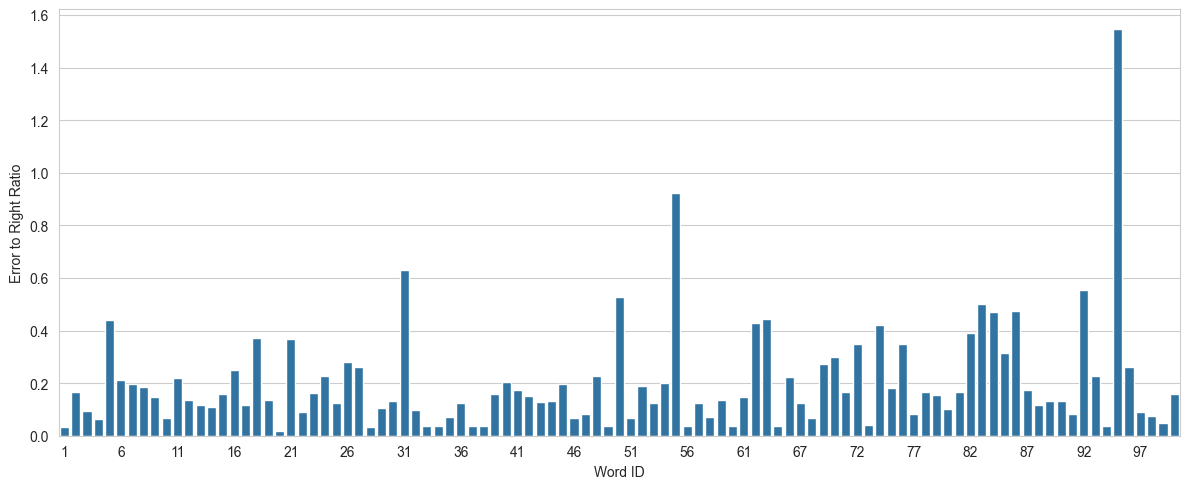

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=error_rate, x='Word ID', y='rate', ax=ax)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))

ax.set_xlabel('Word ID')
ax.set_ylabel('Error to Right Ratio')

plt.tight_layout()

fig.savefig(
    'graphs/error_ratio_plot.png',
    dpi=300,            # разрешение в точках на дюйм
    bbox_inches='tight' # обрезать пустые поля
)

plt.show()

In [7]:
word_X = X_train[X_train['Word ID'] == word_id]
word_y = y_train[X_train['Word ID'] == word_id]

neg_idx = word_y == 0
pos_idx = word_y == 1

neg_audios = [(y, sr) for (y, sr) in zip(word_X[neg_idx]['Audio'], word_X[neg_idx]['SR'])]

pos_audios = [(y, sr) for (y, sr) in zip(word_X[pos_idx]['Audio'], word_X[pos_idx]['SR'])]

print(f'Частота дискретизации выбранная автоматически: {neg_audios[0][1]}')
print(f'Количество отрицательных/Количество положительных:', (len(neg_audios), len(pos_audios)))

Частота дискретизации выбранная автоматически: 22050
Количество отрицательных/Количество положительных: (35, 22)


## Выборочные статистики

In [23]:
n_mfcc = 100

neg_mfcc = [librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) for y, sr in neg_audios]
pos_mfcc = [librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) for y, sr in pos_audios]

In [24]:
def stat_matrix(mfcc: FloatArray) -> pd.DataFrame:
    mfcc = pd.DataFrame(data=mfcc)
    matrix = mfcc.agg(['mean', 'var', 'skew', 'kurt', 'min', 'max', lambda x: x.quantile(0.25)], axis=1)

    matrix.columns = np.append(matrix.columns[:-1], 'q25')
    return matrix

columns = stat_matrix(neg_mfcc[0]).columns
neg_stats = np.stack([stat_matrix(neg_mfcc[i]) for i in range(len(neg_mfcc))], axis=0)
pos_stats = np.stack([stat_matrix(pos_mfcc[i]) for i in range(len(pos_mfcc))], axis=0)

In [29]:
def violin_plot(
        stat_idx: int, 
        k_range: Iterable[int],
        neg_stats: FloatArray,
        pos_stats: FloatArray,
        columns: Sequence,
        ylabel: str,
        xlabel: str = None,
) -> None:
    neg_stats_long = pd.melt(pd.DataFrame(neg_stats[:,:,stat_idx]))
    neg_stats_long[target] = -1

    pos_stats_long = pd.melt(pd.DataFrame(pos_stats[:,:,stat_idx]))
    pos_stats_long[target] = 1

    all_stats = pd.concat([neg_stats_long, pos_stats_long], ignore_index=True)

    print

    mask = (all_stats['variable'].isin(k_range))
    filtered = all_stats[mask]

    plt.figure(figsize=(16, 8))
    sns.violinplot(
        x='variable',
        y='value',
        hue=target,
        data=filtered,
        split=True,                         # склеить два класса в одну скрипку
        inner='quart',                      # квартили
        width=1.2,                          # расширяем скрипки
        palette=sns.color_palette("bright", 2),
        saturation=1.0
    )

    plt.xlabel(xlabel)
    plt.ylabel(f'{ylabel} ({columns[stat_idx]})')
    plt.legend(title='Класс', loc='upper right')
    plt.tight_layout()
    plt.show()

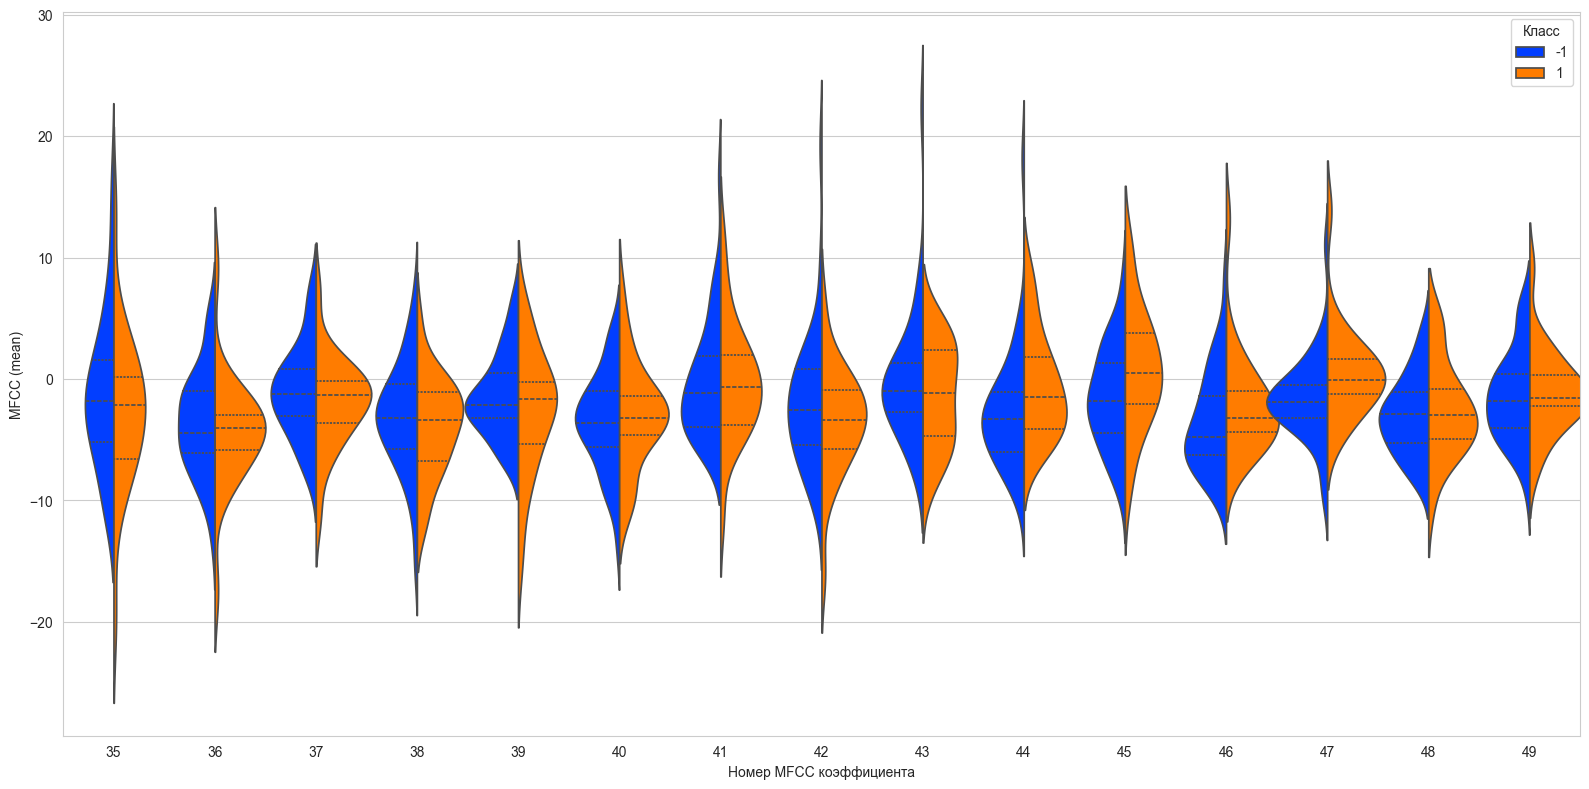

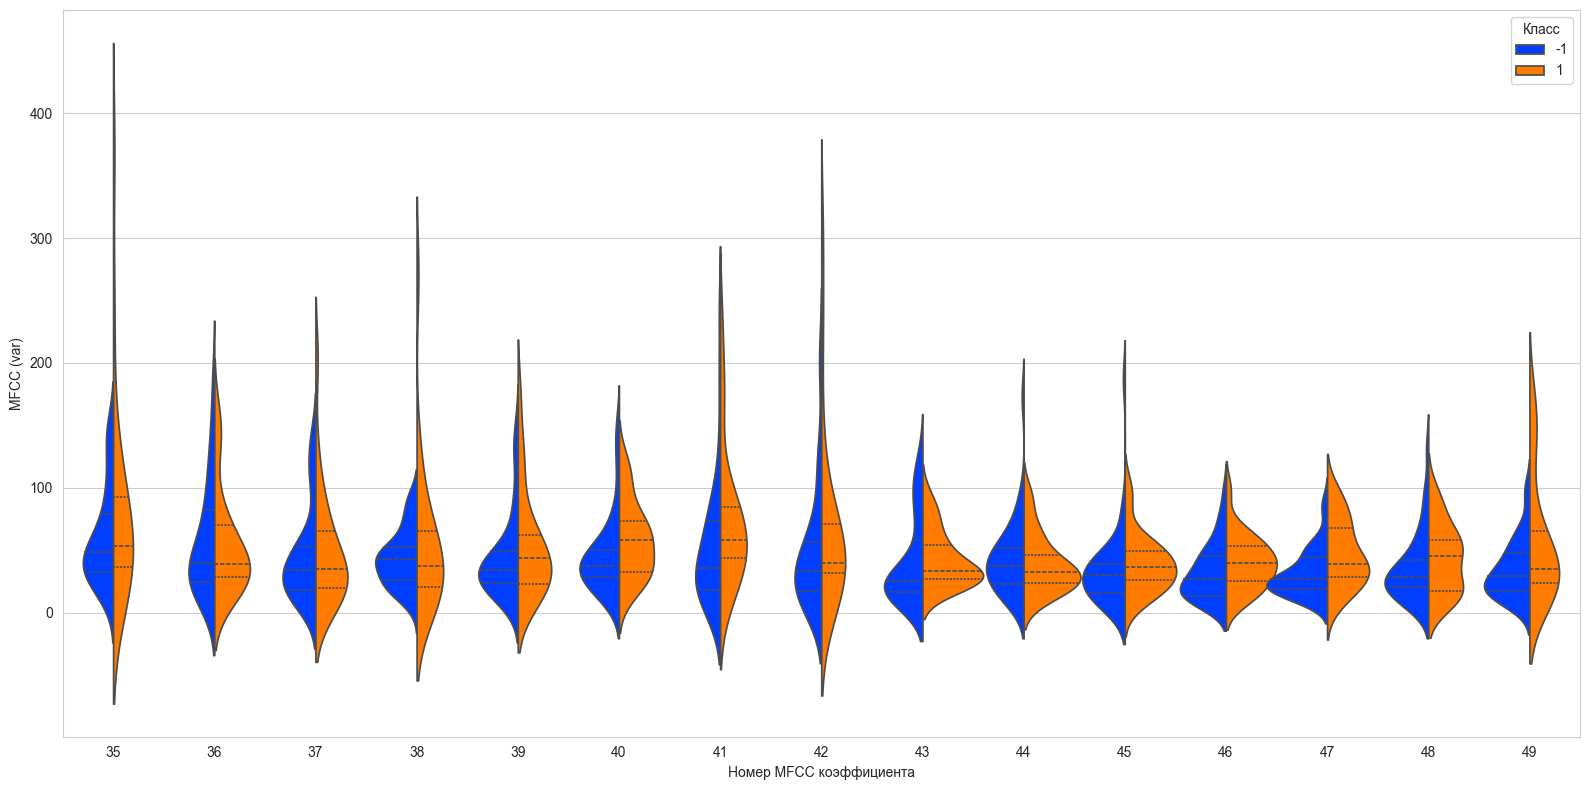

In [26]:
for i in range(2):
    violin_plot(i, range(35, 50), neg_stats, pos_stats, columns, 'MFCC', 'Номер MFCC коэффициента')

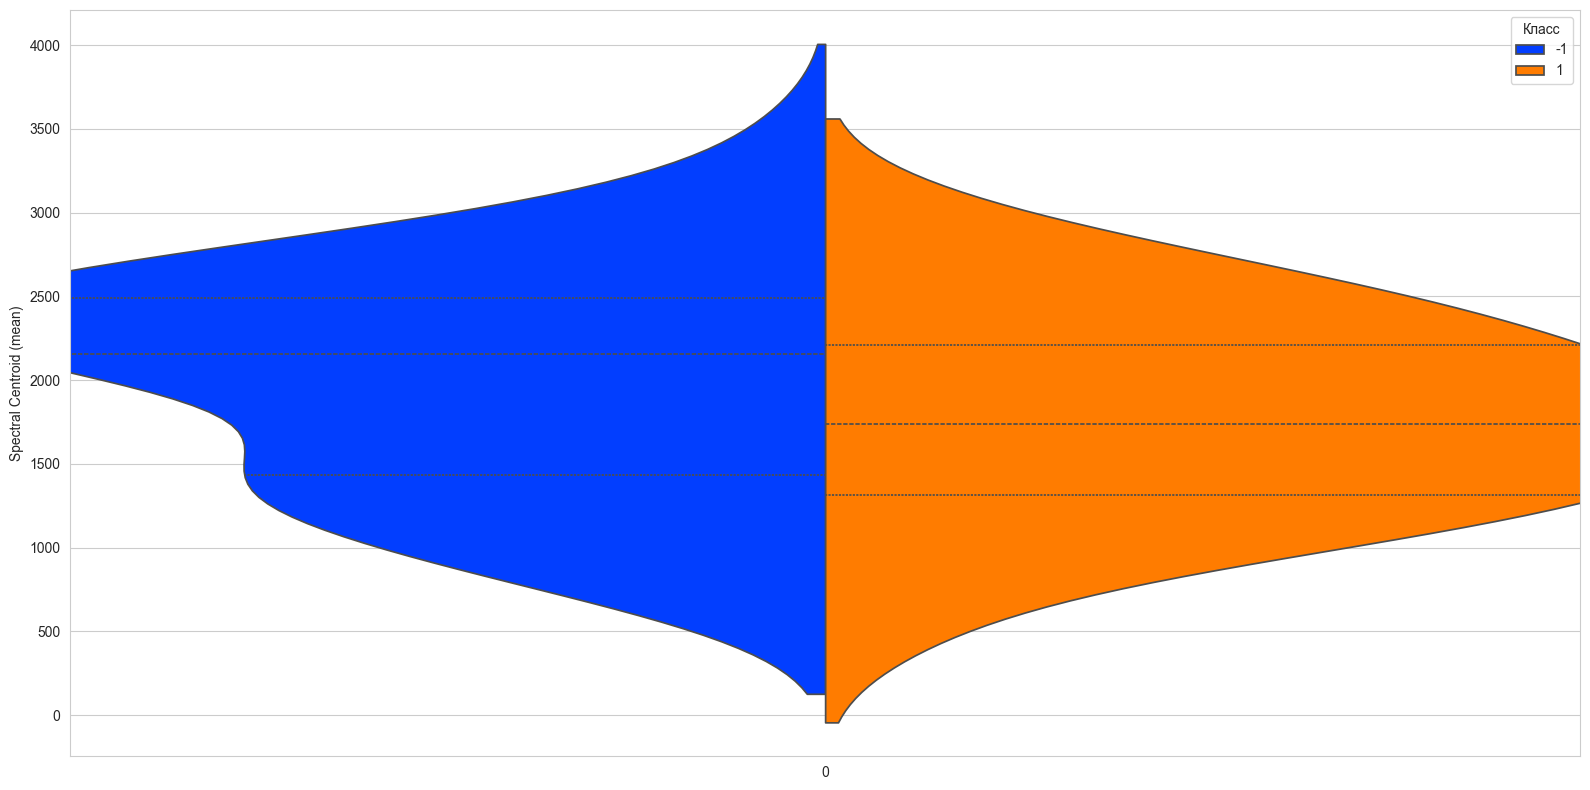

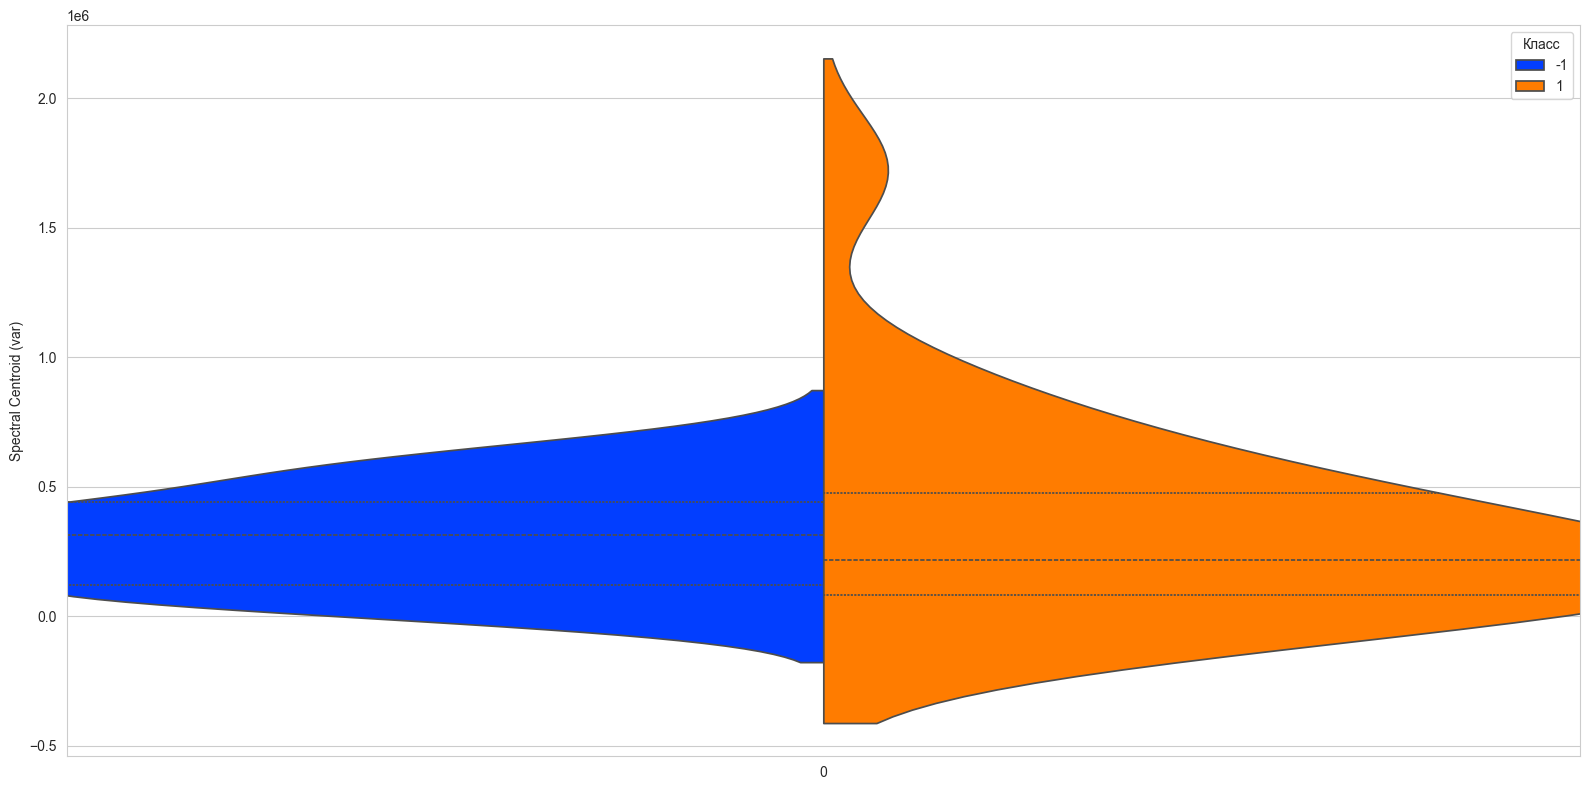

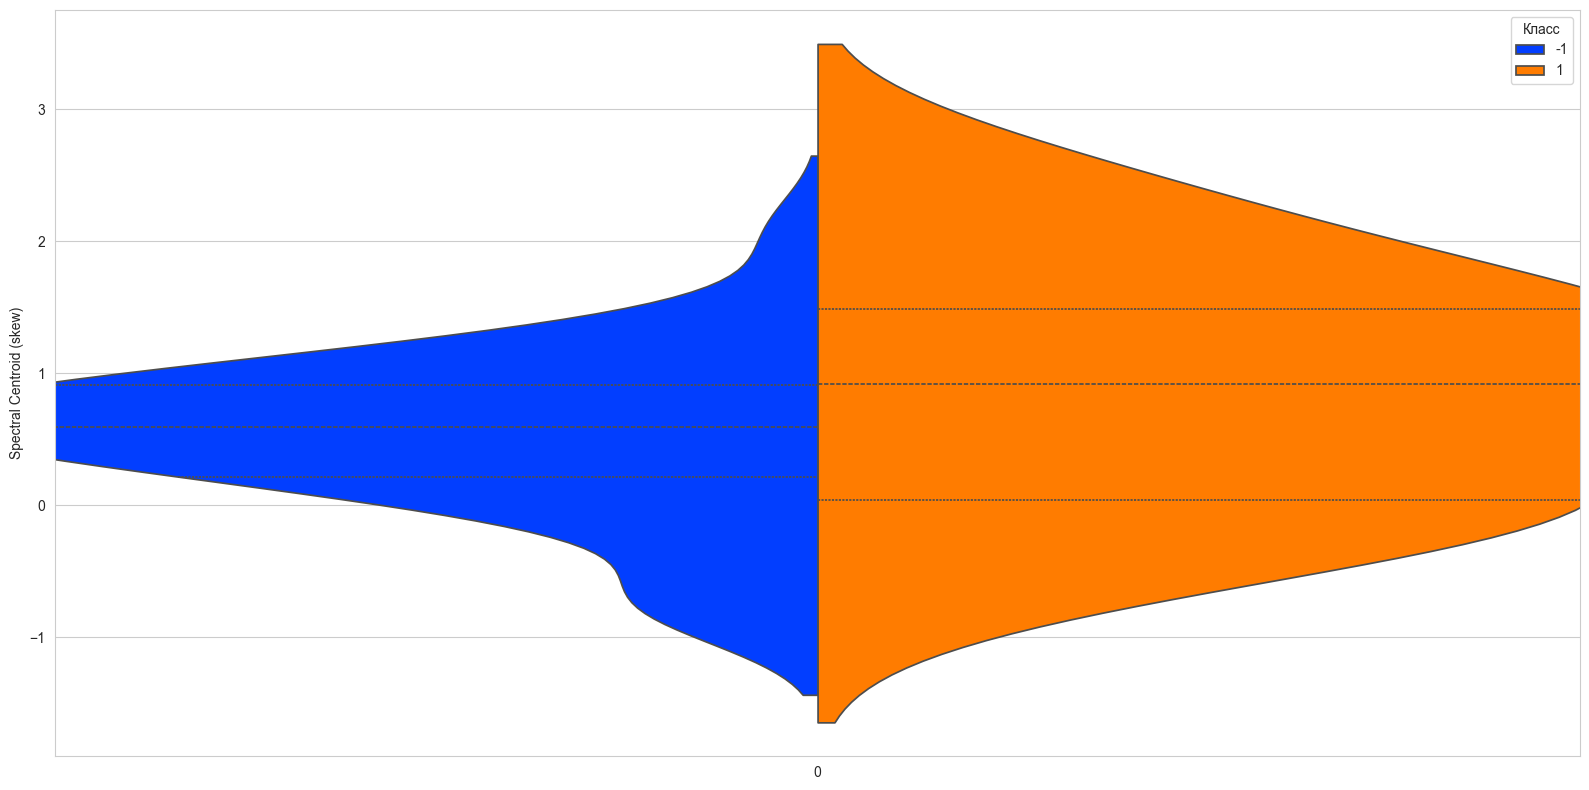

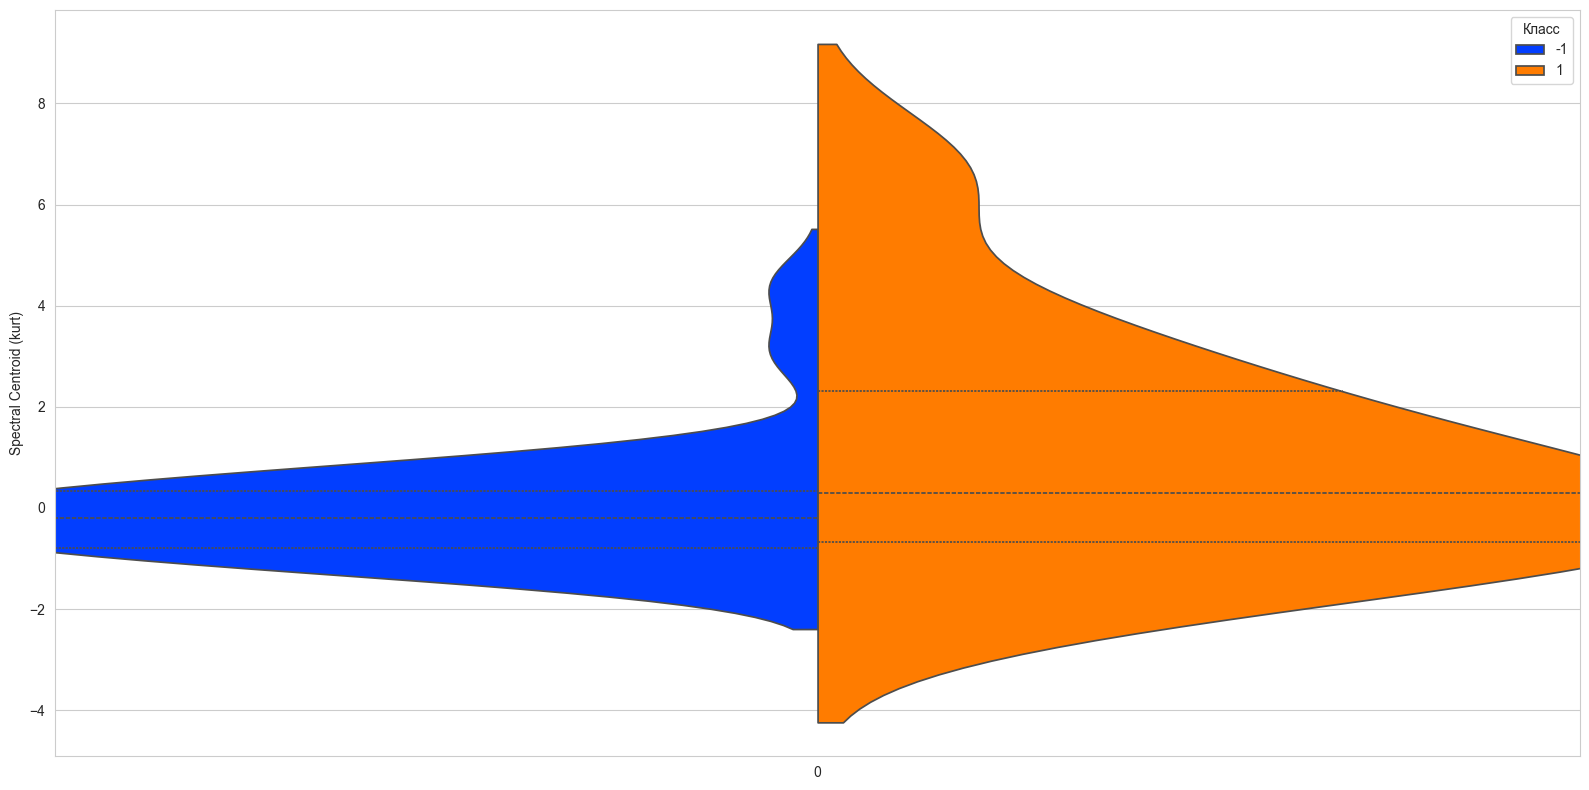

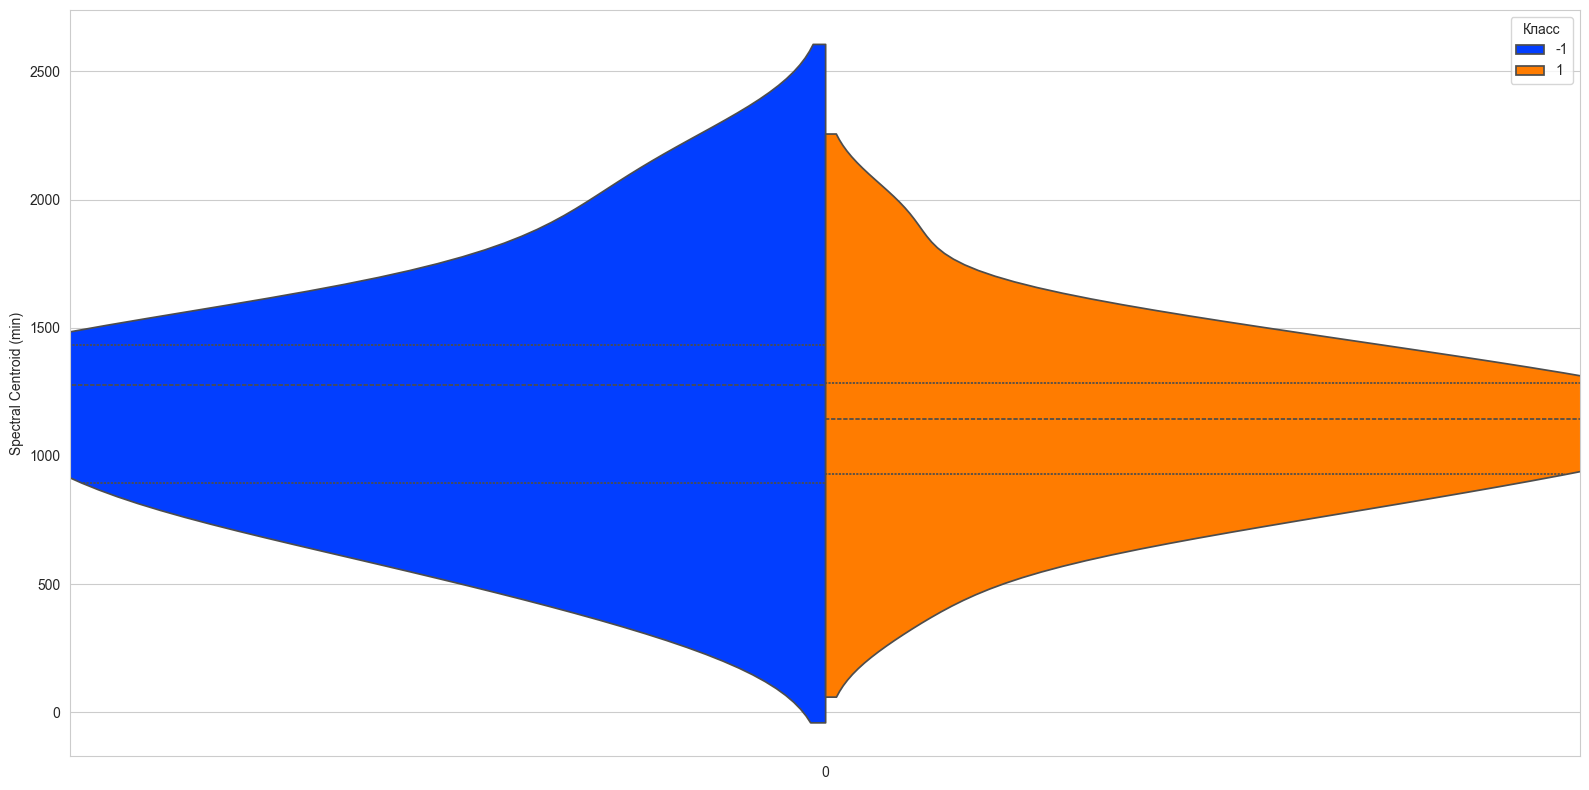

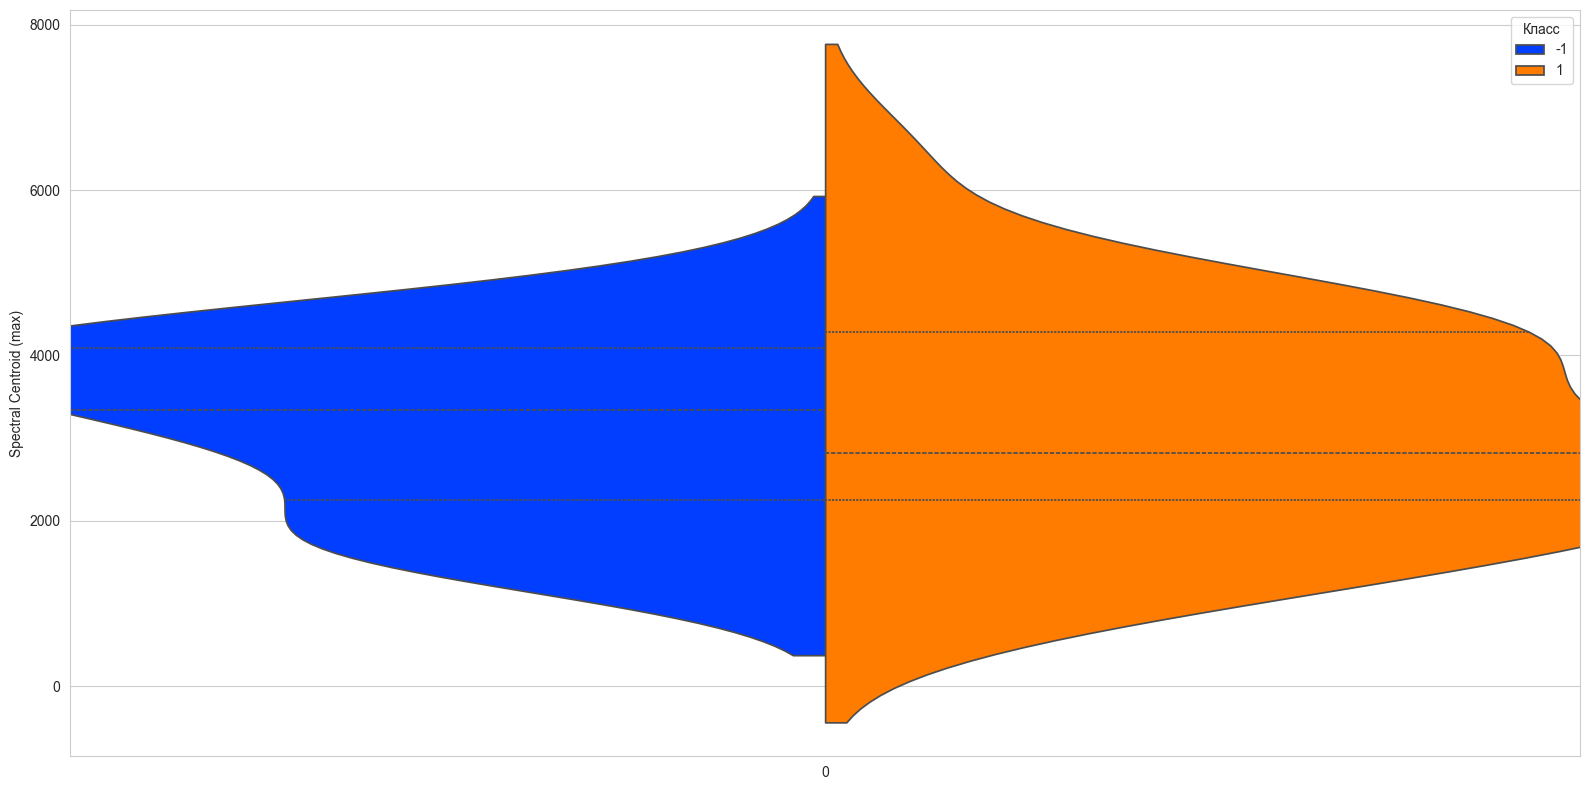

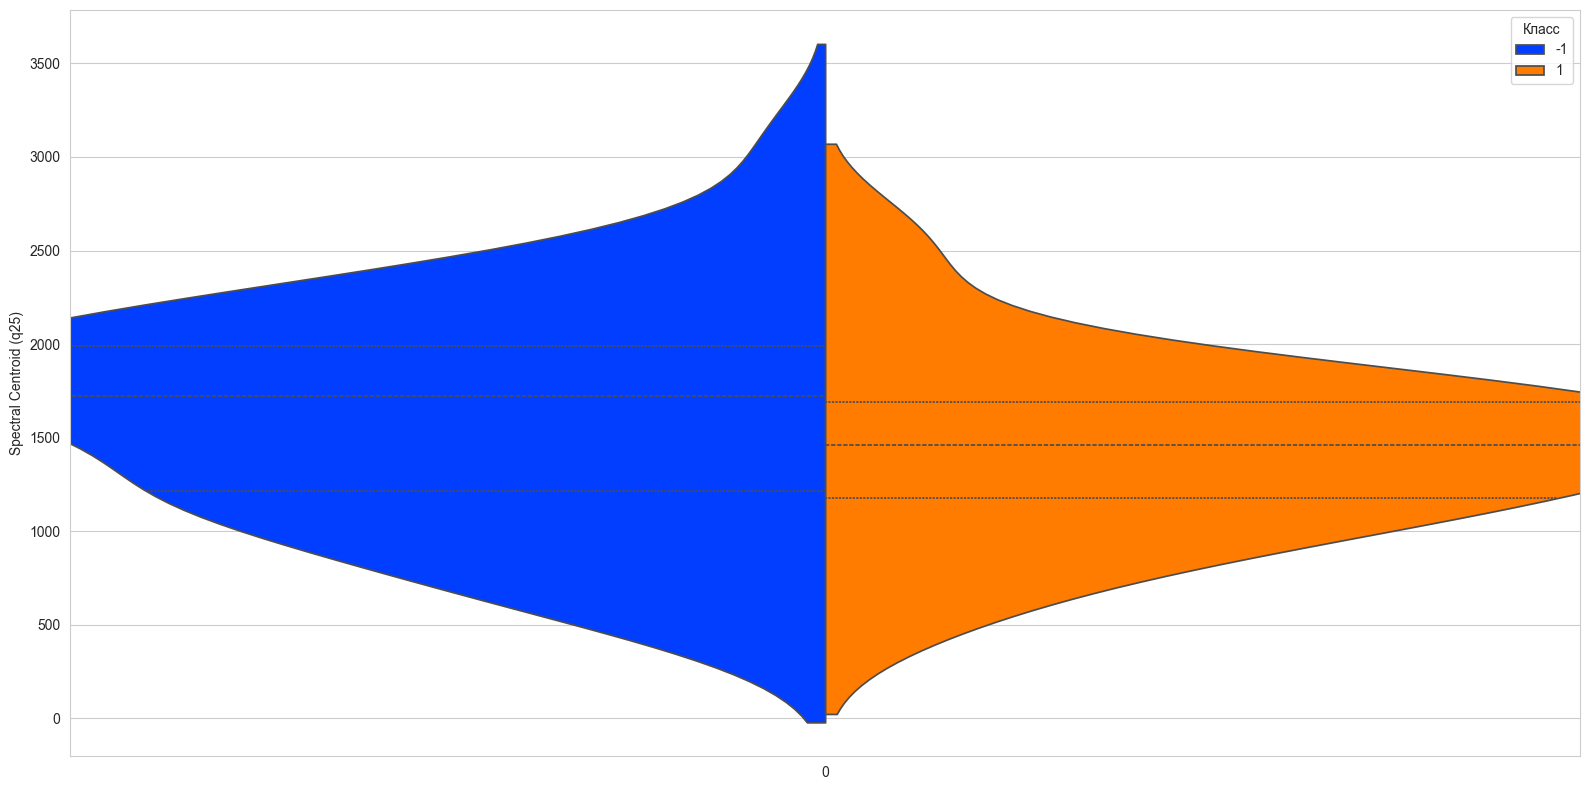

In [30]:
neg_centroid = [librosa.feature.spectral_centroid(y=y, sr=sr) for y, sr in neg_audios]
pos_centroid = [librosa.feature.spectral_centroid(y=y, sr=sr) for y, sr in pos_audios]

columns = stat_matrix(neg_centroid[0]).columns
neg_stats = np.stack([stat_matrix(neg_centroid[i]) for i in range(len(neg_centroid))], axis=0)
pos_stats = np.stack([stat_matrix(pos_centroid[i]) for i in range(len(pos_centroid))], axis=0)

for i in range(len(columns)):
    violin_plot(i, range(50), neg_stats, pos_stats, columns, 'Spectral Centroid')